In [1]:
import numpy as np
import torch
import torchvision
import cv2
import scipy
import matplotlib.pyplot as plt

In [2]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [3]:
def show_image(img: torch.Tensor, channel: int = 0) -> None:
    plt.imshow(img[channel].cpu().detach().numpy(), cmap="grey")

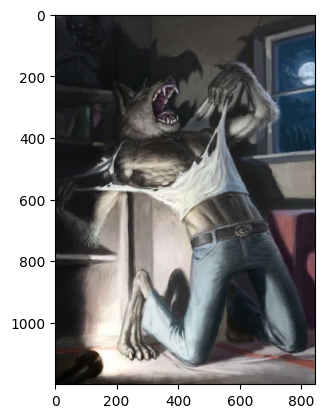

In [347]:
img = cv2.imread("wolf.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### Konwersja obrazu do skali szarości

Wykorzystując odpowiednią konwolucję 3-kanałowy (kolorowy) obraz zostanie zescalony w 1-kanałowy. Wartości z danego kanału będą mnożone przez odpowiedni współczynnik (pierwszy wynik z Google), żeby zachować wierność obrazu dla ludzkiego oka również w skali szarości.

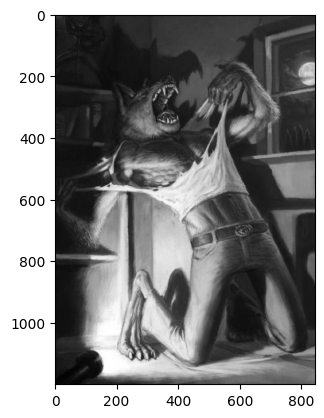

In [384]:
img_tensor = torchvision.transforms.ToTensor()(img).to(device=device)

greyscale_kernel = torch.tensor([0.299, 0.587, 0.114]).reshape(1, 3, 1, 1).to(device=device)
greyscale_conv = torch.nn.Conv2d(3, 1, (1, 1), device=device)
greyscale_conv.weight = torch.nn.Parameter(greyscale_kernel)
grey_img = greyscale_conv(img_tensor)

plt.imshow(grey_img[0].cpu().detach().numpy(), cmap='gray')

### Zmniejszanie obrazu
Do 4-krotnego zmniejszenia wykorzystałem pooling uśredniający, bo dzięki niemu obraz jest "gładszy", czego chcemy (później jeszcze bardziej go "wygładzamy" rozmyciem gaussowskim)

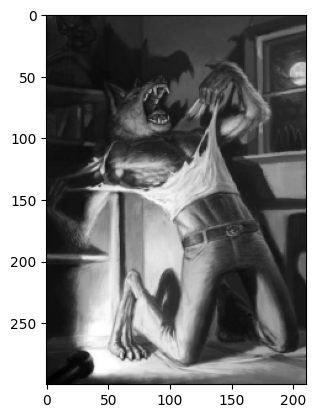

In [389]:
pooling_conv = torch.nn.AvgPool2d((4, 4))
pooled_img = pooling_conv(grey_img)
plt.imshow(pooled_img[0].cpu().detach().numpy(), cmap="grey")

### Rozmycie gaussowskie
Dla wykorzystywanego obrazu najlepiej sprawdza się kernel 3x3, daje on dobry balans między rozmyciem hałasu, a wyraźnością krawędzi 

In [390]:
def gaussian_kernel(size: int) -> torch.Tensor:
    assert size % 2 == 1
    n = np.zeros((size, size), dtype=np.float32)
    n[size // 2, size // 2] = 1
    return torch.from_numpy(scipy.ndimage.gaussian_filter(n, sigma=1)).reshape(1, 1, size, size).to(device=device)

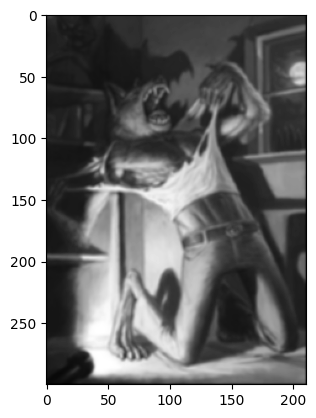

In [391]:
n = 3
gaussian_conv = torch.nn.Conv2d(1, 1, (n, n), padding=n//2, device=device)
gaussian_conv.weight = torch.nn.Parameter(gaussian_kernel(n))
blurred_img = gaussian_conv(pooled_img)
show_image(blurred_img)

### Konwolucje filtrami Sobela

In [361]:
gradient_kernel = torch.Tensor([
    [[
        [1, 0, -1],
        [2, 0, -2],
        [1, 0, -1]
    ]],
    [[
        [1, 2, 1],
        [0, 0, 0],
        [-1, -2, -1]
    ]]
]).to(device=device)
gradient_conv = torch.nn.Conv2d(1, 2, (3, 3), padding=1, device=device)
gradient_conv.weight = torch.nn.Parameter(gradient_kernel)
gradient_img = gradient_conv(blurred_img)

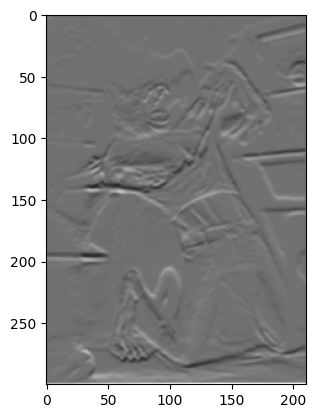

In [365]:
show_image(gradient_img, 1)

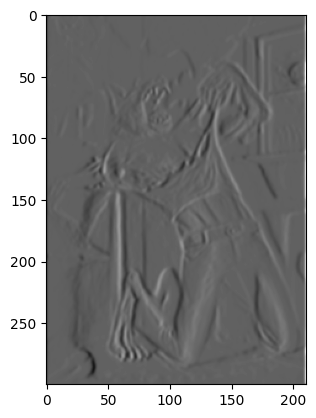

In [366]:
show_image(gradient_img, 0)

### Scalanie kanałów
wygodna funkcja `hypot` robi to, co chcemy - pierwiastek z sumy kwadratów

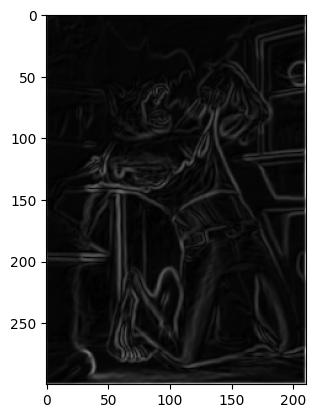

In [392]:
slope_img = torch.hypot(gradient_img[0], gradient_img[1]).unsqueeze(0)
show_image(slope_img)

### Kierunek gradientu
dzieląc kanał konwolucji "pionowej" przez "poziomej" i wyciągając arcusa tangensa z tego ilorazu otrzymujemy kierunek gradientu w każdym pikselu

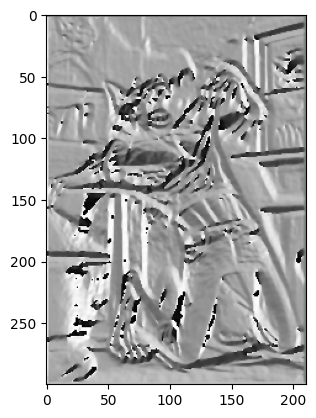

In [393]:
angle_img = torch.arctan2(gradient_img[1], gradient_img[0]).unsqueeze(0)
show_image(angle_img)

### Odchudzanie krawędzi

In [394]:
suppressed_img = torch.zeros(angle_img.shape)

angle = angle_img[0] * 180. / np.pi
angle[angle < 0] += 180
h, w = angle.shape

for i in range(1,h-1):
    for j in range(1,w-1):
        try:
            #angle 0
            if 0 <= angle[i,j] < 22.5 or 157.5 <= angle[i,j] <= 180:
                q = slope_img[0, i, j+1]
                r = slope_img[0, i, j-1]
            #angle 45
            elif 22.5 <= angle[i,j] < 67.5:
                q = slope_img[0, i+1, j-1]
                r = slope_img[0, i-1, j+1]
            #angle 90
            elif 67.5 <= angle[i,j] < 112.5:
                q = slope_img[0, i+1, j]
                r = slope_img[0, i-1, j]
            #angle 135
            elif 112.5 <= angle[i,j] < 157.5:
                q = slope_img[0, i-1, j-1]
                r = slope_img[0, i+1, j+1]
            if slope_img[0, i, j] >= q and slope_img[0, i, j] >= r:
                suppressed_img[0, i, j] = slope_img[0, i, j]
            else:
                suppressed_img[0, i, j] = 0
        except IndexError as e:
            pass

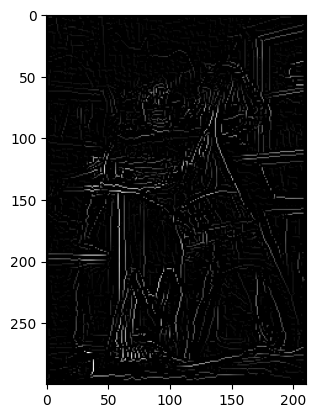

In [375]:
show_image(suppressed_img)

### Wyzerowanie niskich wartości gradientu

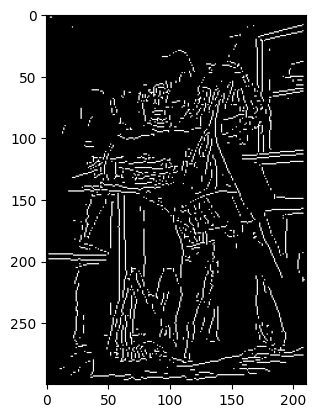

In [395]:
high_threshold_ratio=0.15
high_threshold = torch.max(suppressed_img) * high_threshold_ratio
threshold_img = torch.where(suppressed_img > high_threshold, 1.0, 0.0)
show_image(threshold_img)

### Powiększenie krawędzi i nałożenie ich na oryginalny obraz
położenie krawędzi ma sens, ale nie ma ich wszędzie, gdzie bym się ich spodziewał

In [379]:
upscaled_result_img = torch.nn.functional.interpolate(threshold_img.unsqueeze(0), scale_factor=4, mode="nearest")[0].to(device=device)

In [396]:
overlay_img = torch.zeros_like(img_tensor)
indices = torch.where(upscaled_result_img > 0.5)
overlay_img[0, indices[1], indices[2]] = 1 
overlay_img[1, indices[1], indices[2]] = 0
overlay_img[2, indices[1], indices[2]] = 0
final_img = img_tensor * (overlay_img == 0) + overlay_img

In [381]:
res = torchvision.transforms.ToPILImage()(final_img)

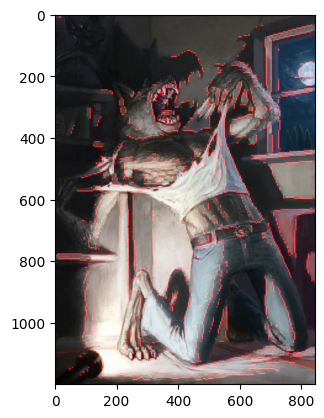

In [382]:
plt.imshow(res)